# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    # pct_change_true = y_true.pct_change() * 100
    # pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = y_true - y_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

In [3]:
def adj_tracking_error(y_true, X_test, model):
    cost = 0.001  # 0.1% cost
    X_test_adjusted = X_test.copy()
    X_test_adjusted[0, :] -= cost  # Subtract cost from the first return of each stock

    # Predict with adjustment
    y_pred_adjusted = model.predict(X_test_adjusted)
    return tracking_error(y_true, y_pred_adjusted)

# Data

In [4]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [5]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [6]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [7]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 639555


In [8]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [9]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [10]:
threshold = 0.10
# Drop columns with more than the threshold percentage of missing values
df = df.dropna(thresh=int((1-threshold) * len(df)), axis=1)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

df.dropna(axis=0, inplace=True)

df.index = df.index.tz_localize(None)

zero_rows = (df == 0.0).any(axis=1)

num_zero_rows = zero_rows.sum()

print(f"Number of rows with 0.0 values: {num_zero_rows}")
print(f"Total rows {len(df)}")

Number of rows with NaN values: 37207
Number of rows with 0.0 values: 79
Total rows 639981


In [11]:
len(df.columns)

88

In [12]:
df_total = df.join(nifty_100_closing, how='left')

In [13]:
df_total.dropna(inplace=True)

In [14]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 42


In [15]:
print(len(df_total))

629791


In [16]:
df_total.sort_index(inplace=True)

# Models

## Combined Approach
In this section, we will utilize a combined approach to limit the number of features (stocks) and train our models.

1. Feature Selection (using Lasso w/ high alpha, Mutual Info, ANOVA, RFE)
2. Define threshold to drop features
3. Train model on reduced feature space (Hyperparameter tuned)
4. Get tracking error
5. Save pair (number of stocks, tracking error) for plotting

### Lasso - Lasso

We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [17]:
from sklearn.preprocessing import StandardScaler

def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=5)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        train_period = X.iloc[train_index].index
        test_period = X.iloc[test_index].index
        
        # Convert to date format
        train_start_date, train_end_date = train_period.min(), train_period.max()
        test_start_date, test_end_date = test_period.min(), test_period.max()
        
        print(f"Train period: {train_start_date} to {train_end_date}")
        print(f"Test period: {test_start_date} to {test_end_date}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        #for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_):
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_cv)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
    
            y_pred = lasso.predict(X_selected_test)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_selected_test, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

----------Starting alpha 0.001-------------
Train period: 2015-02-02 10:19:00 to 2016-06-14 11:27:00
Test period: 2016-06-14 11:28:00 to 2017-09-07 11:02:00
Selected 71 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.037162753753355905
Train period: 2015-02-02 10:19:00 to 2017-09-07 11:02:00
Test period: 2017-09-07 11:03:00 to 2018-12-06 15:04:00
Selected 74 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.03788367845018229
Train period: 2015-02-02 10:19:00 to 2018-12-06 15:04:00
Test period: 2018-12-06 15:05:00 to 2020-04-27 09:57:00
Selected 75 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.0789119392269766
Train period: 2015-02-02 10:19:00 to 2020-04-27 09:57:00
Test period: 2020-04-27 09:58:00 to 2021-07-27 12:26:00
Selected 75 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.05117952341278683
Train period: 2015-02-02 10:19:00 to 2021-07-27 12:26:00
Test period: 2021-07-27 12:27:00 to 2022-10-24 19:14:00
Selected 77 stocks
Best Alpha for t

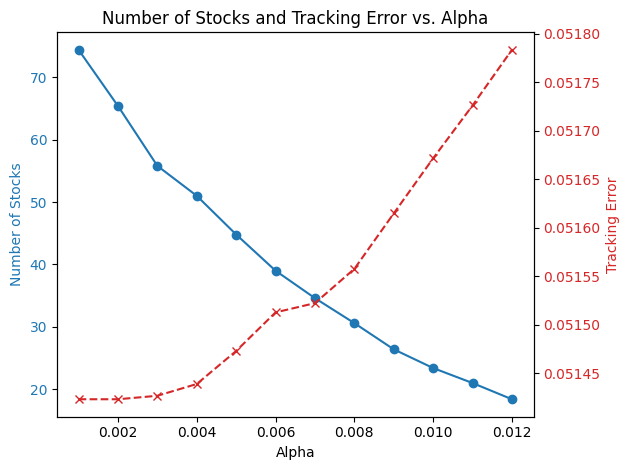

In [18]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]
tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

for alpha in alphas:
    print(f"----------Starting alpha {alpha}-------------")
    _, num_stocks, tracking_err, adj_tracking_err = Lasso_Lasso(alpha, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Number of Stocks', color=color)
ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for tracking error
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
#ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
ax2.plot(alphas, adj_tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and legend
plt.title('Number of Stocks and Tracking Error vs. Alpha')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Mutual Info - Lasso
Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [19]:
from sklearn.preprocessing import StandardScaler

def MI_Lasso(percentile, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)
        
        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]
    
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_train_selected, y_train_cv)
    
            y_pred = lasso.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

Starting percentile: 0.0
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03711004575155275
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03786548963142361
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.07887967392419576
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.05115319071879367
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.04783309931005052
Alpha: 0.012, Average Tracking Error: 0.05056829986720326
Starting percentile: 0.1
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03712650912196169
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03787101852297473
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.07893567992809461
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.05116791991676884
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.04785834218217817
Al

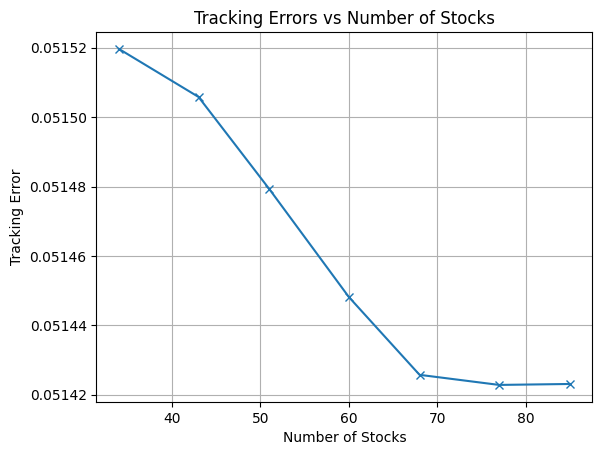

In [20]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]
tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    _, num_stocks, tracking_err, adj_tracking_err = MI_Lasso(percentile, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('Tracking Errors vs Number of Stocks')
plt.grid(True)
plt.show()

### MI - Polynomial Regression

In [21]:
from sklearn.preprocessing import StandardScaler

def MI_Polynomial(percentile, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    num_stocks = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)
        
        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]
    
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))    
        
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('linear', LinearRegression())
        ])
        
        model.fit(X_train_selected, y_train_cv)
        y_pred = model.predict(X_test_selected)
        fold_score = tracking_error(y_test_cv.values, y_pred)
        adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, model)

        scores.append(adj_fold_score)

    # Calculate average scores for each degree
    average_scores = np.mean(scores)
    average_selected_features = np.mean(num_stocks)

    return average_selected_features, average_scores

Starting percentile: 0.6
Selected 34 stocks
Selected 34 stocks
Selected 34 stocks
Selected 34 stocks
Selected 34 stocks
Starting percentile: 0.7
Selected 26 stocks
Selected 26 stocks
Selected 26 stocks
Selected 26 stocks
Selected 26 stocks


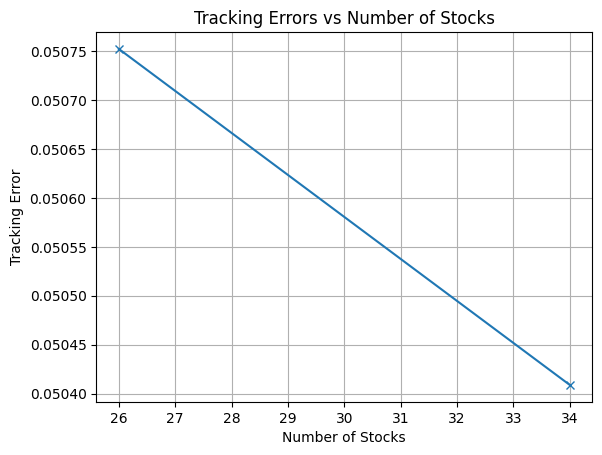

In [22]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']


percentiles = [0.6, 0.7]
num_stocks_list = []
scores = []

for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    num_stocks, score = MI_Polynomial(percentile, X, y)
    num_stocks_list.append(num_stocks)
    scores.append(score)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, scores, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('Tracking Errors vs Number of Stocks')
plt.grid(True)
plt.show()

TODO: Theil-Sein Linear Regression